In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784")

In [3]:
from sklearn.preprocessing import StandardScaler
mnist_data, mnist_target = mnist.data.values, mnist.target.values
X, y = StandardScaler().fit_transform(mnist_data), mnist_target.astype(np.int)
y_ = np.zeros((y.size, 10))
y_[np.arange(y.size), y] = 1

In [56]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  C = np.max(x)
  exps = np.exp(x - C)
  if x.ndim == 1:
    sum_exps = np.sum(exps)
    return exps / sum_exps
  sum_exps = np.sum(exps, axis=1)
  return (exps.T / sum_exps).T

def cross_entropy_error(y, t):
  if y.ndim == 1:
    y = y.reshape(1, y.size)
    t = t.reshape(1, t.size)
  batch_size = t.shape[0]
  return -np.sum( t * np.log(y + 1e-4) ) / batch_size

def get_gradient(f, x):
  h = 1e-4
  grad = np.zeros(x.shape)
  for i, v in np.ndenumerate(x):
    temp = x[i]
    x[i] -= h
    f1 = f(x)
    x[i] += 2*h
    f2 = f(x)
    x[i] = temp
    grad[i] = ((f2 - f1) / (2 * h)).mean()
  return grad

In [6]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    
    self.params['input_size'] = input_size
    self.params['hidden_size'] = hidden_size
    self.params['output_size'] = output_size
    
    self.params['W1'] = np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)
    return y

  def loss(self, x, t):
    y = self.predict(x)
    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    if y.ndim == 1:
      d = 1
      y = np.argmax(y)
      t = np.argmax(t)
    else:
      d = y.shape[0]
      y = np.argmax(y, axis=1)
      t = np.argmax(t, axis=1)
    accuracy = np.sum(y == t) / float(d)
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.predict(x)
    grads = {}
    grads['W1'] = get_gradient(loss_W, self.params['W1'])
    grads['b1'] = get_gradient(loss_W, self.params['b1'])
    grads['W2'] = get_gradient(loss_W, self.params['W2'])
    grads['b2'] = get_gradient(loss_W, self.params['b2'])
    return grads

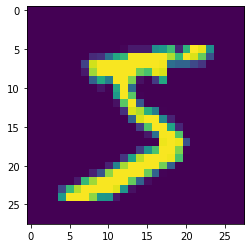

In [13]:
plt.imshow(mnist_data[0].reshape(28, -1))

In [20]:
def im2col(X, FH, FW, stride=1, pad=0):
  if X.ndim == 2:
    X = X.copy().reshape(1, 1, X.shape[0], X.shape[1])
  elif X.ndim == 3:
    X = X.copy().reshape(1, X.shape[0], X.shape[1], X.shape[2])
  N, C, H, W = X.shape
  OH = (H + 2*pad - FH) // stride + 1
  OW = (W + 2*pad - FW) // stride + 1
  img = np.pad(X, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, OH, OW, C, FH, FW))

  for i in range(OH):
    ii = i * stride
    for j in range(OW):
      jj = j * stride
      col[:, i, j, :, :, :] = img[:, :, ii:ii+FH, jj:jj+FW]
  col = col.reshape(N*OH*OW, -1)
  return col

In [22]:
def col2im(col, input_shape, FH, FW, stride=1, pad=0):
  N, C, H, W = input_shape
  OH = (H + 2 * pad - FH) // stride + 1
  OW = (W + 2 * pad - FW) // stride + 1
  col = col.reshape(N, OH, OW, C, FH, FW)
  img = np.zeros((N, C, H+2*pad, W+2*pad))
  for h in range(OH):
    ii = h * stride
    for w in range(OW):
      jj = w * stride
      img[:,:,ii:ii+FH, jj:jj+FW] = col[:, h, w, :, :, :]
  return img[:, :, pad:pad+H, pad:pad+W]

In [35]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
  
  def forward(self, X):
    if X.ndim == 2:
      X = X.copy().reshape(1, 1, X.shape[0], X.shape[1])
    elif X.ndim == 3:
      X = X.copy().reshape(1, X.shape[0], X.shape[1], X.shape[2])
    N, C, H, W = X.shape

    out_h = (H - self.pool_h) // self.stride + 1
    out_w = (W - self.pool_w) // self.stride + 1
    col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)
    out = np.max(col, axis=1)
    out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
    return out

In [49]:
p = Pooling(2, 2, stride=2)
mnist_data_3d = mnist_data.reshape(-1, 1, 28, 28)
compacted_data = p.forward(mnist_data_3d)

In [50]:
compacted_data.shape

(70000, 1, 14, 14)

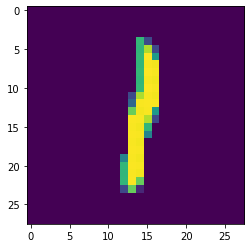

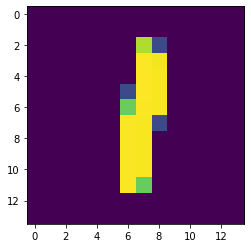

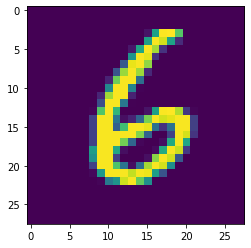

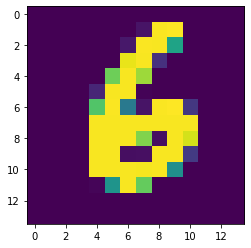

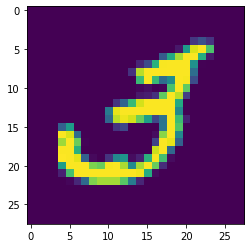

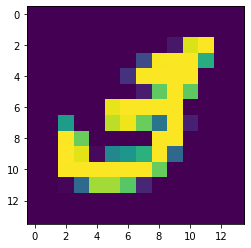

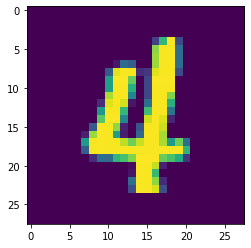

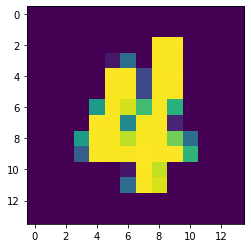

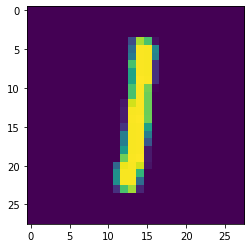

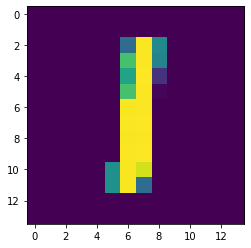

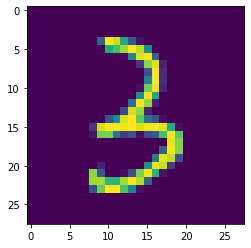

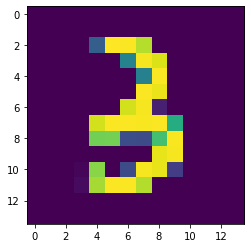

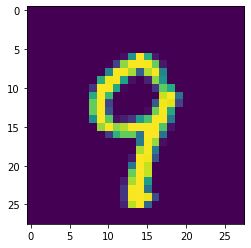

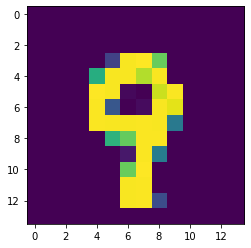

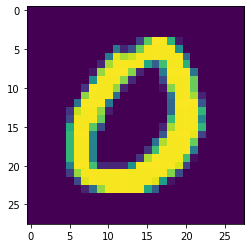

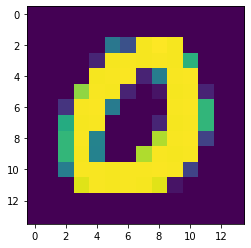

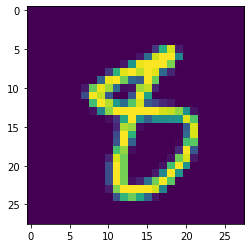

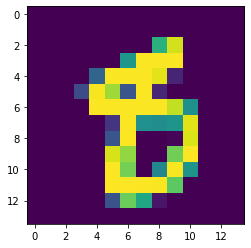

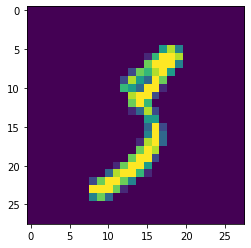

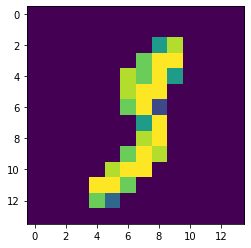

In [51]:
show_batch_size = 10
show_batch_targets = np.random.choice(mnist_data.shape[0], show_batch_size)

for i in show_batch_targets:
  plt.figure()
  plt.imshow(mnist_data[i].reshape(28, 28))
  plt.figure()
  plt.imshow(compacted_data[i,0])

In [52]:
compacted_data = compacted_data[:, 0, :, :].reshape(compacted_data.shape[0], -1)
compacted_data.shape

(70000, 196)

In [53]:
X_ = StandardScaler().fit_transform(compacted_data)

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.1)

In [57]:
iters = 10000
lr = 0.01
batch_size = 100
epoch_size = max((iters // batch_size) , 1)
train_acc_list = []
test_acc_list = []
train_loss_list = []
net = TwoLayerNet(196, 50, 10)

for i in range(iters):
  targets = np.random.choice(X_train.shape[0], batch_size)
  X_batch, y_batch = X_train[targets], y_train[targets]

  grads = net.numerical_gradient(X_batch, y_batch)

  for key in ('W1', 'b1', 'W2', 'b2'):
    net.params[key] -= lr * grads[key]
  loss = net.loss(X_batch, y_batch)
  train_loss_list.append(loss)

  if i % epoch_size == 0:
    train_acc = net.accuracy(X_train ,y_train)
    test_acc = net.accuracy(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("Train acc : {}, Test acc : {}".format(train_acc, test_acc))

Train acc : 0.08711111111111111, Test acc : 0.08342857142857144
Train acc : 0.08711111111111111, Test acc : 0.08342857142857144
Train acc : 0.08711111111111111, Test acc : 0.08342857142857144


KeyboardInterrupt: ignored